In [1]:
import pandas as pd
import numpy as np
from patternly.detection import StreamingDetection
from sklearn.cluster import KMeans

original = pd.read_csv("./01_2015_LANL-01A_SOPA_MPA.txt", low_memory=False).dropna(how="any", axis=0)

In [2]:
%%time

START_COL = 0
END_COL = 3
WINDOW_SIZE = 1000
OVERLAP = 0
N_CLUSTERS = 2

predictions = pd.DataFrame()
pipelines = []

for i in range(START_COL, END_COL):
    data = original.iloc[:,i+1].replace(-1e+31, np.nan).dropna(how="all", axis=0)

    kmeans = KMeans(n_clusters=N_CLUSTERS)
    pipelines.append(
        StreamingDetection(
            window_size=WINDOW_SIZE,
            window_overlap=OVERLAP,
            anomaly_sensitivity=1, 
            clustering_alg=kmeans,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
        )
    )
    pipelines[i - START_COL].fit(data)

    predictions = pd.concat([predictions, pd.DataFrame(pipelines[i - START_COL].predict())], axis=1)

predictions.columns = range(predictions.shape[1])

CPU times: user 20.8 s, sys: 1.81 s, total: 22.6 s
Wall time: 8.36 s


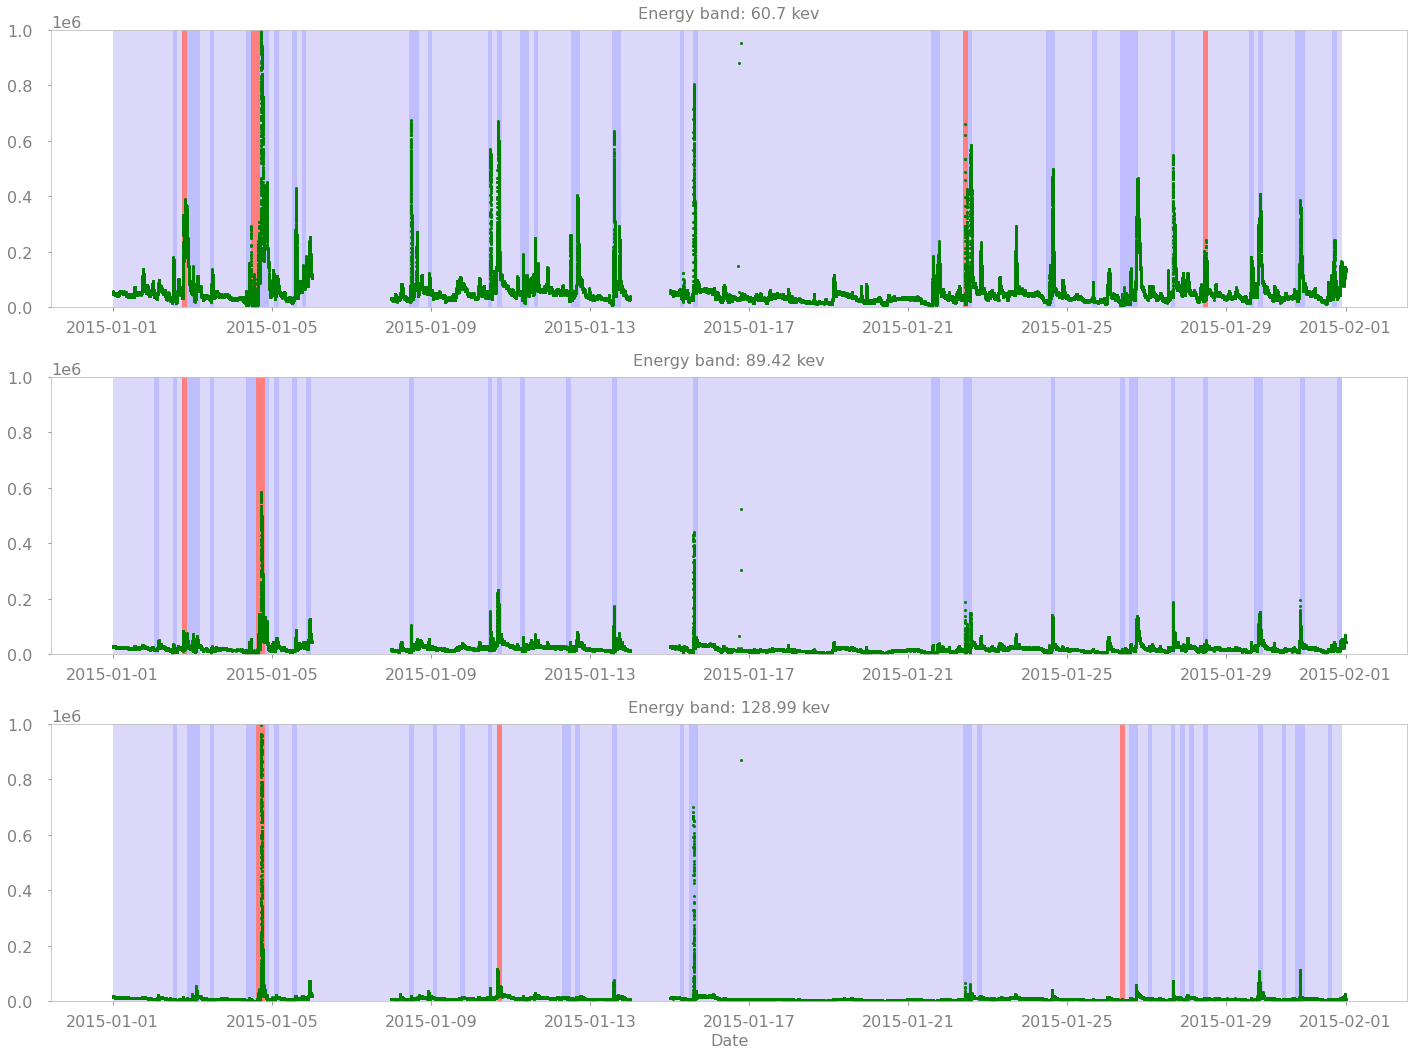

CPU times: user 24.8 s, sys: 1.08 s, total: 25.9 s
Wall time: 25 s


In [3]:
%%time

import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams["figure.figsize"] = (20,15)

dts = pd.DataFrame(
    [datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0]],
    index=original.index
)

for i in range(START_COL, END_COL):
    # align sequence values with timestamps
    seqs = original.iloc[:,i+1].replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(END_COL-START_COL, 1, i+1-START_COL)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), color="green", markersize=2, zorder=2)
    
    # highlight anomalies
    anoms = list(predictions[predictions[i - START_COL] == True].index)
    for index in anoms:
        beg = data["ts"].iloc[(index * WINDOW_SIZE) - (index * OVERLAP)]
        end = data["ts"].iloc[min(((index + 1) * WINDOW_SIZE) - (index * OVERLAP), data["ts"].shape[0] - 1)]
        plt.axvspan(beg, end, color='red', alpha=0.5, lw=0, zorder=1)
        
    # highlight non-anomalies by cluster
    colors = ["#7766ee", "blue", "darkgreen", "darkorange", 'cyan']
    non_anomalies = predictions[i - START_COL][predictions[i - START_COL] == False]
    for index in non_anomalies.index:
        beg = data["ts"].iloc[(index * WINDOW_SIZE) - (index * OVERLAP)]
        end = data["ts"].iloc[min(((index + 1) * WINDOW_SIZE) - (index * OVERLAP), data["ts"].shape[0] - 1)]
        color = colors[pipelines[i-START_COL].closest_match[index]]
        plt.axvspan(beg, end, color=color, alpha=0.25, lw=0, zorder=0)
        
    ax = plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16, y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5', pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title('Energy band: '+original.columns[i+1]+' kev', fontsize=16, y=1.02, color='.5')
    if i == END_COL-1:
        ax.set_xlabel('Date', fontsize=16, color='.5')
        

plt.tight_layout(pad=2)
plt.show()

In [4]:
from IPython.display import Image, display
from IPython.core.display import HTML

# column 1 PFSAs
for i, file in enumerate(pipelines[0].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1


In [5]:
# column 2 PFSAs
for i, file in enumerate(pipelines[1].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1


In [6]:
# column 3 PFSAs
for i, file in enumerate(pipelines[2].dot_files):
    print(f"Cluster {i}")
    display(Image(url=f"{file}.png", width=300))

Cluster 0


Cluster 1
